In [1]:
# Here are some common libraries that expand the functionality of python
import math         # sine, cosine, sqrt, etc.
import numpy as np  # so we can work with matrices

import matplotlib
import matplotlib.pyplot as plt # plotting
import sympy as sp # symbolic calculations

Define the number of degrees of freedom (x,y,theta,z...), and the position of the nodes. 

In [2]:
DoF = 3

In [3]:
# [x1,y1], ... the (x,y) position of node 1, 2, 3...
global nodes
nodes = np.array([
    [0,0],
    [1,0],
    [2,0],
    [3,0],
    [4,0],
    [5,0],
    [0.5,1],
    [1.5,1],
    [2.5,1],
    [3.5,1],
    [4.5,1]
])
# a list of all the nodes numbers
node_numbers = np.array([*range(len(nodes))])
global node_DoF
node_DoF = np.array([*range(DoF*len(nodes))])

Define elements and their characteristics 

In [4]:
###### element e is connected at nodes i and j
# element e: [node i, node j, Young's Modulus, Cross Sectional Area,Second Moment of Area] ... note: we'll calculate L later
global elements
elements = np.array([
    [1,2,0.25*210e9,1,1.5e-5],
    [2,3,0.25*210e9,1,1.5e-5],
    [3,4,0.25*210e9,1,1.5e-5],
    [4,5,0.25*210e9,1,1.5e-5],
    [5,6,0.25*210e9,1,1.5e-5],
    [1,7,0.25*210e9,1,1.5e-5],
    [7,2,0.25*210e9,1,1.5e-5],
    [2,8,0.25*210e9,1,1.5e-5],
    [8,3,0.25*210e9,1,1.5e-5],
    [3,9,0.25*210e9,1,1.5e-5],
    [9,4,0.25*210e9,1,1.5e-5],
    [4,10,0.25*210e9,1,1.5e-5],
    [10,5,0.25*210e9,1,1.5e-5],
    [5,11,0.25*210e9,1,1.5e-5],
    [11,6,0.25*210e9,1,1.5e-5],
    [7,8,0.25*210e9,1,1.5e-5],
    [8,9,0.25*210e9,1,1.5e-5],
    [9,10,0.25*210e9,1,1.5e-5],
    [10,11,0.25*210e9,1,1.5e-5],
    [1,9,0.25*210e9,1e3,1.5e-5],
    [9,4,0.25*210e9,1e3,1.5e-5],
    [1,9,0.25*210e9,1e3,1.5e-5],
    [9,6,0.25*210e9,1e3,1.5e-5],
    [7,4,0.25*210e9,1e9,1.5e-5],
    [3,11,0.25*210e9,1e9,1.5e-5]
])

Plot the undeformed structure 

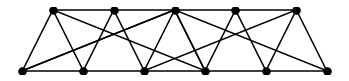

In [5]:
# set axes aspect ratio = 1
# turn off the axis
plt.axes().set_aspect('equal') 
plt.axis('off') 

# plot the nodes
plt.plot(nodes[:,0], nodes[:,1], 'k.',markersize=15)
# plot the elements
# loop through the list of elements, grab the x position and y position of each node associated with that element
# the line: 'elements[i,0]-1' is necessary because python starts counting at 0, not 1 (like MATLAB)
for i in range(len(elements)):
    plt.plot(np.array([
    nodes[int(elements[i,0]-1),0], nodes[int(elements[i,1]-1),0]]),
         np.array([nodes[int(elements[i,0]-1),1], nodes[int(elements[i,1]-1),1]]),
         'k-')
plt.show()


Define the Dirichlet/geometric boundary conditions

In [6]:
# dirichlet boundary conditions
# [node, DoF (x=1, y=2 , theta=3), value]  THETA ADDED
#number of node as on the image 
bc = np.array([
    [1,1,0],
    [1,2,0],
    [6,2,0],
    [6,1,0]
])

In [7]:
## neumann boundary conditions - e.g. forces
# [node, DoF (x=1,y=2,theta = 3), magnitude of force]
forces = np.array([
    [1,2,-30e7],
    [2,2,-30e7],
    [3,2,-30e7],
    [4,2,-30e9],
    [5,2,-30e7],
    [6,2,-30e7]
])

In [8]:
# initializing the vectors F, u, and the matrix K
ForcesandMoments = u = np.zeros(DoF*len(nodes)) #[N_i,V_i,M_i,N_j,V_j,M_j]
K0 = np.zeros([DoF*len(nodes), DoF*len(nodes)])

In [9]:
def XY(element):
    return np.array([
        nodes[int(elements[element,0]-1)],
        nodes[int(elements[element,1]-1)]
    ])

In [10]:
# for element e, what degrees of freedom in the structure do the nodes correspond to?
def elementDoF(element):
    node_i = int(elements[element,:DoF][0])-1 # -1 is for python counting
    node_j = int(elements[element,:DoF][1])-1 # -1 is for python counting
    
    elementDoF = np.array([
        [node_DoF[DoF*node_i]],
        [node_DoF[DoF*node_i+1]],
        [node_DoF[DoF*node_i+2]],
        [node_DoF[DoF*node_j]],
        [node_DoF[DoF*node_j+1]],
        [node_DoF[DoF*node_j+2]],
    ])

    return elementDoF

In [11]:
elementDoF(0)

array([[0],
       [1],
       [2],
       [3],
       [4],
       [5]])

In [12]:
# elemental stiffness matrix in global coordinates
def Kel(element):
    XY1 = XY(element)
    x1, y1, x2, y2 = XY1[0,0], XY1[0,1], XY1[1,0], XY1[1,1]
    E = elements[element][2]
    A = elements[element][3]
    I = elements[element][4]
    L = math.sqrt((x2-x1)**2 + (y2-y1)**2)
    c = (x2-x1)/L
    s = (y2-y1)/L
        
    #KGLOBAL = TRANSPOSE(T)*KLOCAL*T
    
    Kel_L =np.array([
        [E*A/L,0,0,-E*A/L,0,0],
        [0,12*E*I/(L**3),6*E*I/(L**2),0,-12*E*I/(L**3),6*E*I/(L**2)],
        [0,6*E*I/(L**2),4*E*I/L,0,-6*E*I/(L**2),2*E*I/L],
        [-E*A/L,0,0,E*A/L,0,0],
        [0,-12*E*I/(L**3),-6*E*I/(L**2),0,12*E*I/(L**3),-6*E*I/(L**2)],
        [0,6*E*I/(L**2),2*E*I/L,0,-6*E*I/(L**2),4*E*I/L]
    ]) 
    
    T = np.array([
        [c,s,0,0,0,0],
        [-s,c,0,0,0,0],
        [0,0,1,0,0,0],
        [0,0,0,c,s,0],
        [0,0,0,-s,c,0],
        [0,0,0,0,0,1]
        ])
    
    
    
    Kel = np.transpose(T).dot(Kel_L).dot(T)
     
    return Kel

In [13]:
# augment the elemental stiffness matrix by adding rows & columns of zeroes at the missing nodes
def Kaug(e):
    """"""
    Kel1 = Kel(e)
    kaug = np.zeros([DoF*len(nodes), DoF*len(nodes)])
    i = elementDoF(e)[0][0]#0 
    j = elementDoF(e)[1][0]#1
    m = elementDoF(e)[2][0]#2
    k = elementDoF(e)[3][0]#3
    l = elementDoF(e)[4][0]#4
    n = elementDoF(e)[5][0]#5
    
    kaug[i][i] += Kel1[0][0] 
    kaug[i][j] += Kel1[0][1]
    kaug[i][m] += Kel1[0][2]
    kaug[j][i] += Kel1[1][0]
    kaug[j][j] += Kel1[1][1]
    kaug[j][m] += Kel1[1][2]
    kaug[m][i] += Kel1[2][0]
    kaug[m][j] += Kel1[2][1]
    kaug[m][m] += Kel1[2][2]

    kaug[k][k] += Kel1[3][3]
    kaug[k][l] += Kel1[3][4]
    kaug[k][n] += Kel1[3][5]
    kaug[l][k] += Kel1[4][3]
    kaug[l][l] += Kel1[4][4]
    kaug[l][n] += Kel1[4][5]
    kaug[n][k] += Kel1[5][3]
    kaug[n][l] += Kel1[5][4]
    kaug[n][n] += Kel1[5][5]    
    
    kaug[i][k] += Kel1[0][3]
    kaug[i][l] += Kel1[0][4]    
    kaug[i][n] += Kel1[0][5]
    kaug[j][k] += Kel1[1][3]    
    kaug[j][l] += Kel1[1][4]
    kaug[j][n] += Kel1[1][5]    
    kaug[m][k] += Kel1[2][3]
    kaug[m][l] += Kel1[2][4]   
    kaug[m][n] += Kel1[2][5]
    kaug[k][i] += Kel1[3][0]
    kaug[k][j] += Kel1[3][1]    
    kaug[k][m] += Kel1[3][2]
    kaug[l][i] += Kel1[4][0]    
    kaug[l][j] += Kel1[4][1]
    kaug[l][m] += Kel1[4][2]
    kaug[n][i] += Kel1[5][0]    
    kaug[n][j] += Kel1[5][1]
    kaug[n][m] += Kel1[5][2]
   
    
    return kaug

In [14]:
Kaug(0)

array([[5.250e+10, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [0.000e+00, 9.450e+06, 4.725e+06, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [0.000e+00, 4.725e+06, 3.150e+06, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       ...,
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00]])

In [15]:
def MasterStiffness():
# Calculate the Master Stiffness matrix:
# 1. Get the x & y coordinates of each node connected to element i
# 2. Calculate the stiffness matrix for element i
# 3. Augment the elemental stiffness matrix to the size of K
# 4. Add it to K, loop over the remaining elements
    K = np.zeros([DoF*len(nodes), DoF*len(nodes)])
    for i in range(len(elements)):
        nodesXY = XY(i)
        K += Kaug(i)
    return K

In [16]:
K = MasterStiffness()
K

array([[ 3.36791565e+13,  1.34656837e+13, -3.86502332e+06, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.34656837e+13,  5.41633910e+12,  7.62568873e+06, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-3.86502332e+06,  7.62568873e+06,  8.30720691e+06, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.68086298e+19,  6.72345190e+18,  7.00391383e+06],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         6.72345190e+18,  2.68938083e+18, -5.33011067e+06],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         7.00391383e+06, -5.33011067e+06,  9.95477193e+06]])

In [17]:
# initialize vectors for the specified displacements and forces. these will be [1 x DoF]
u_specified=[]
F_specified=[0]*DoF*len(nodes)

# what DoF are specified?
for i in range(len(bc)):
    u_specified.append(DoF*(bc[i,0]-1)+bc[i,1]-1)
# assign the external forces to the corresponding DoF in F   
for i in range(len(forces)):    
    F_specified[int((DoF*(forces[i,0]-1)+forces[i,1])-1)]=forces[i,2]
    
print(F_specified,u_specified)
u_unknown = np.delete(u,u_specified) # deleting the specified displacments from u
K_reduced = np.delete(K,u_specified,0) # deleting rows
K_reduced = np.delete(K_reduced,u_specified,1) # deleting columns
F_specified = np.delete(F_specified,u_specified) # deleting the forces that correspond to specified displacments

[0, -300000000.0, 0, 0, -300000000.0, 0, 0, -300000000.0, 0, 0, -30000000000.0, 0, 0, -300000000.0, 0, 0, -300000000.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] [0, 1, 16, 15]


In [18]:
K_reduced

array([[ 8.30720691e+06,  0.00000000e+00, -4.72500000e+06,
         1.57500000e+06,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  3.38093478e+06,
        -1.69046739e+06,  1.40872283e+06,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  4.84088537e+05,
        -1.21022134e+06,  1.16988063e+06,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  1.23793790e+11,  0.00000000e+00,
        -6.76186956e+06, -5.25000000e+10,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -9.39689500e+09,
         1.87802663e+10, -3.38093478e+06, -9.39689500e+09,
        -1.87802663e+10, -3.38093478e+06,  0.00000000e+00,
         0.00

Now we know have everything inside the linear system. We must solve for the unknown.

In [19]:
# np.linalg.lstsq does the matrix left division. 
# it returns the residuals, rank, etc. of the calculation, so we just grab the list, which is element [0]
u_unknown = np.linalg.lstsq(K_reduced,F_specified, rcond=None)[0]

In [20]:
u_unknown

array([ 0.14896016, -0.07942244,  0.11760287,  0.03731972, -0.15434632,
        0.06547486, -0.13086081, -0.22760169, -0.11930836, -0.18939533,
       -0.09754682, -0.13904721,  0.05000087,  0.14839388, -0.1410487 ,
        0.09707411,  0.0724434 , -0.06933689,  0.11026983, -0.04967998,
        0.00073621, -0.00434625, -0.17666133, -0.05995684, -0.16167771,
       -0.06462303, -0.09099349, -0.0929072 ,  0.06360298])

In [21]:
# create a list of all the displacement degrees of freedom (DoF)
u_DoF=[]
for i in range(len(u)):
    u_DoF.append(i)

# get the index locations of the free degrees of freedom (DoF)    
u_free = (list(set(u_DoF) - set(u_specified)))    

# put the free (formerly unknown) displacements into the displacement vector u
np.put(u,u_free,u_unknown)

In [22]:
print('%.10f'%u[3])

-0.0794224366


In [23]:
nodes_new = nodes + np.reshape(u,(len(nodes),DoF))[:,0:2]
nodes_new
np.reshape(u,(len(nodes),DoF))[:,0:2]

array([[ 0.        ,  0.        ],
       [-0.07942244,  0.11760287],
       [-0.15434632,  0.06547486],
       [-0.22760169, -0.11930836],
       [-0.09754682, -0.13904721],
       [ 0.        ,  0.        ],
       [-0.1410487 ,  0.09707411],
       [-0.06933689,  0.11026983],
       [ 0.00073621, -0.00434625],
       [-0.05995684, -0.16167771],
       [-0.09099349, -0.0929072 ]])

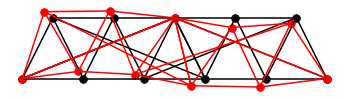

In [24]:
# set axes aspect ratio = 1
# turn off the axis

plt.axes().set_aspect('equal') 
plt.axis('off') 

# plot the nodes
plt.plot(nodes[:,0], nodes[:,1], 'k.',markersize=15)
plt.plot(nodes_new[:,0], nodes_new[:,1], 'r.',markersize=15)
# plot the elements
# loop through the list of elements, grab the x position and y position of each node associated with that element
# the line: 'elements[i,0]-1' is necessary because python starts counting at 0, not 1 (like MATLAB)
for i in range(len(elements)):
    plt.plot(np.array([
    nodes[int(elements[i,0]-1),0], nodes[int(elements[i,1]-1),0]]),
         np.array([nodes[int(elements[i,0]-1),1], nodes[int(elements[i,1]-1),1]]),
         'k-')
# plot the deformed elements
for i in range(len(elements)):
    plt.plot(np.array([
    nodes_new[int(elements[i,0]-1),0], nodes_new[int(elements[i,1]-1),0]]),
         np.array([nodes_new[int(elements[i,0]-1),1], nodes_new[int(elements[i,1]-1),1]]),
         'r-')    
plt.show()